In [336]:
import concurrent.futures
import multiprocessing
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import sqlite3
import seaborn as sns

import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import threading
import numpy as np
from sqlalchemy import create_engine
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

pd.set_option('display.max_columns', None)


def read_sql_table(query):
    engine = create_engine('sqlite:///soccer_statistics.db', echo=False)
    df = pd.read_sql(query, con=engine)
    # df.to_csv('penalties.csv')
    return df


query = """select p.match_id,
				s.[index],
				p.[index] [pindex],
				p.home_team,
				p.away_team,
				p.competition,
				p.round,
				p.type,
				p.time,
				m.date,
				p.foot,
				p.location,
				p.event_outcome,
				p.taker,
				p.team,
				s.away_score,
				s.home_score,
				max(CASE WHEN (s.goal_time- p.time) < 0 THEN (s.goal_time- p.time) END)[gt],
				group_concat(CASE WHEN (s.goal_time- p.time) < 0 AND scoring_team = "away" THEN goal_scorer END, ',  ')  [away_scorers],
				group_concat(CASE WHEN (s.goal_time- p.time) < 0 AND scoring_team = "home" THEN goal_scorer END, ',  ')  [home_scorers]

		from penalties p
		left outer join scores s
		on p.match_id = s.match_id
		left join (select date, match_id
							from  match_commentary
							GROUP By match_id) m on p.match_id = m.match_id
		GROUP BY p.match_id,
				 p.[index]"""

df = read_sql_table(query)


In [340]:

df = df[df['time'] != 120.0]

df['year'] = df['date'].str.split('-', -1, expand=True)[0]
#df_prem = df[(df['competition'] == 'English Premier League') | (df['competition'] == 'Barclays Premier League')]
#df_prem['competition'] = 'English Premier League'
#df_prem = pd.read_excel('df_prem.xlsx')
df_prem = df.sort_values('date')
df_prem['taken_before'] = np.where((df_prem.duplicated('taker')), 1, 0)
df_prem['prior_pens']=df_prem.groupby('taker')['taker'].cumcount()
df_prem = df_prem[df_prem['location'] != 'miss']
df_prem['period'] = pd.cut(df_prem['time'], right=False, bins=[-1, 16, 31, 46, 61, 76, 91, 106, 130], labels=[1, 2, 3, 4, 5, 6, 7, 8])
open_body = ((df_prem['foot'] == 'left foot') & (df_prem['location'].str.contains('left'))) | \
            ((df_prem['foot'] == 'right foot') & (df_prem['location'].str.contains('right')))

cross_body = ((df_prem['foot'] == 'left foot') & (df_prem['location'].str.contains('right'))) | \
             ((df_prem['foot'] == 'right foot') & (df_prem['location'].str.contains('left')))

df_prem['pen_direction'] = np.where(open_body, 'open body', np.where(cross_body, 'cross body', 'center'))
df_prem['pen_location'] = np.where(df_prem['location'].str.contains('left'), 'left', np.where(df_prem['location'].str.contains('right'), 'right', 'center'))
fuzz_ratio = df_prem.apply(lambda x: (fuzz.ratio(x['home_team'], x['team']))-(fuzz.ratio(x['away_team'], x['team'])), axis=1)
df_prem['taking_team'] = np.where(fuzz_ratio > 0, 'home','away')
df_prem['home_scorers'] = np.where(df_prem['home_scorers'].isna(), '', df_prem['home_scorers'])
df_prem['away_scorers'] = np.where(df_prem['away_scorers'].isna(),'',df_prem['away_scorers'])
df_prem['score_difference'] = df_prem['home_score'] - df_prem['away_score']
home_winning = (df_prem['taking_team']=='home') & (df_prem['home_score']-df_prem['away_score'] > 0)
home_losing = (df_prem['taking_team']=='home') & (df_prem['home_score']-df_prem['away_score'] < 0)
home_tied = (df_prem['taking_team']=='home') & (df_prem['home_score']-df_prem['away_score'] == 0)
df_prem['home_winning_tied_losing'] = np.where(home_winning, 'winning', np.where(home_losing, 'losing', 'tied'))
df_prem['prior_goals'] = [x.home_scorers.count(x.taker) for x in df_prem.itertuples()]
df_prem['score_within_one'] = np.where(abs(df_prem['home_score'] - df_prem['away_score']) <= 2, 1, 0)
df_prem['score_within_one*time'] = df_prem['score_within_one'] * df_prem['time']
# df_prem.value_counts('location')
df_prem

,match_id,index,pindex,home_team,away_team,competition,round,type,time,date,foot,location,event_outcome,taker,team,away_score,home_score,gt,away_scorers,home_scorers,year,taken_before,prior_pens,period,pen_direction,pen_location,taking_team,score_difference,home_winning_tied_losing,prior_goals,score_within_one,score_within_one*time
0,315136,1,35,France,Germany,FIFA Women's World Cup,Group Stage 2011,penalty---scored,68.00,2011-07-05,right foot,bottom right,goal,Inka Grings,Germany,2,1,-12.00,"Kerstin Garefrekes, Inka Grings",Marie-Laure Delie,2011,0,0,5,open body,right,away,-1,tied,0,1,68.00
1,315160,0,88,Sweden,United States,FIFA Women's World Cup,Group Stage 2011,penalty---scored,16.00,2011-07-06,right foot,top left,goal,Lisa Dahlkvist,Sweden,0,0,-16.00,,,2011,0,0,2,cross body,left,home,0,tied,0,1,16.00
2,315166,2,3,Equatorial Guinea,Brazil,FIFA Women's World Cup,Group Stage 2011,penalty---scored,90.03,2011-07-06,left foot,bottom right,goal,Cristiane,Brazil,2,0,-36.03,"Erika, Cristiane",,2011,0,0,6,cross body,right,away,-2,tied,0,1,90.03
17,323673,3,85,Brazil,United States,FIFA Women's World Cup,Quarter-finals,penalty---scored,68.00,2011-07-10,left foot,bottom right,goal,Marta,Brazil,1,0,-66.00,Daiane,,2011,0,0,5,cross body,right,home,-1,losing,0,1,68.00
39,325253,1,18,Guadalajara,Real Madrid,World Football Challenge,None,penalty---scored,76.00,2011-07-20,right foot,bottom right,goal,Cristiano Ronaldo,Real Madrid,1,0,-3.00,Cristiano Ronaldo,,2011,0,0,6,open body,right,away,-1,tied,0,1,76.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29012,632714,0,7,Barcelona SC,América-MG,Copa Libertadores,Third Stage,penalty---scored,95.00,None,right foot,top right,goal,Emmanuel Martínez,Barcelona de Guayaquil,0,0,-95.00,,,None,1,1,7,open body,right,home,0,tied,0,1,95.00
29013,632714,0,8,Barcelona SC,América-MG,Copa Libertadores,Third Stage,penalty---scored,94.00,None,right foot,top left,goal,Iago Maidana,América Mineiro,0,0,-94.00,,,None,1,5,7,cross body,left,away,0,tied,0,1,94.00
29014,632714,0,9,Barcelona SC,América-MG,Copa Libertadores,Third Stage,penalty---scored,93.00,None,right foot,center,goal,Byron Castillo,Barcelona de Guayaquil,0,0,-93.00,,,None,1,1,7,center,center,home,0,tied,0,1,93.00
29015,632714,0,10,Barcelona SC,América-MG,Copa Libertadores,Third Stage,penalty---scored,92.00,None,right foot,bottom right,goal,Wellington Paulista,América Mineiro,0,0,-92.00,,,None,1,20,7,open body,right,away,0,tied,0,1,92.00


In [177]:
print(df_prem.value_counts('event_outcome', normalize=True))
for location in df_prem.value_counts('location').index:
    print(location, ": ", df_prem[df_prem['location'] == location].value_counts('event_outcome', normalize=True))

print(df_prem.value_counts('foot', normalize=True))
for foot in df_prem.value_counts('foot').index:
    print(foot, ": ", df_prem[df_prem['foot'] == foot].value_counts('event_outcome', normalize=True))

print(df_prem.value_counts('pen_direction', normalize=True))
for direction in df_prem.value_counts('pen_direction').index:
    print(direction, ": ", df_prem[df_prem['pen_direction'] == direction].value_counts('event_outcome', normalize=True))

event_outcome
goal    0.834575
save    0.152012
miss    0.013413
dtype: float64
bottom left :  event_outcome
goal    0.804348
save    0.195652
dtype: float64
bottom right :  event_outcome
goal    0.833333
save    0.166667
dtype: float64
center :  event_outcome
goal    0.848921
save    0.151079
dtype: float64
top left :  event_outcome
goal    0.977778
save    0.022222
dtype: float64
top right :  event_outcome
goal    0.977273
save    0.022727
dtype: float64
miss :  event_outcome
miss    1.0
dtype: float64
foot
right foot    0.852459
left foot     0.147541
dtype: float64
right foot :  event_outcome
goal    0.835664
save    0.148601
miss    0.015734
dtype: float64
left foot :  event_outcome
goal    0.828283
save    0.171717
dtype: float64
pen_direction
cross body    0.412817
open body     0.366617
center        0.220566
dtype: float64
cross body :  event_outcome
goal    0.826715
save    0.173285
dtype: float64
open body :  event_outcome
goal    0.865854
save    0.134146
dtype: float64
cen

In [178]:

def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

# cols = df_prem[['foot','pen_direction','period','']].columns
# fig = plt.figure(figsize=(30,10))
# for feature, i in zip(cols, range(1,len(cols)+1)):
#     ax = fig.add_subplot(1,len(cols)+1,i)
#     sns.histplot(data=df_prem, x=feature, hue='event_outcome', multiple='dodge', ax=ax)
#     percentage_above_bar_relative_to_xgroup(ax)


<ipython-input-178-7fb2e54c7878>:6: RuntimeWarning: invalid value encountered in long_scalars
  percentage = f'{(100 * p.get_height() / total) :.1f}%'
<ipython-input-178-7fb2e54c7878>:6: RuntimeWarning: invalid value encountered in long_scalars
  percentage = f'{(100 * p.get_height() / total) :.1f}%'


ConversionError: Failed to convert value(s) to axis units: 0        2011
1        2011
2        2011
17       2011
39       2011
         ... 
29012    None
29013    None
29014    None
29015    None
29016    None
Name: x, Length: 25661, dtype: object

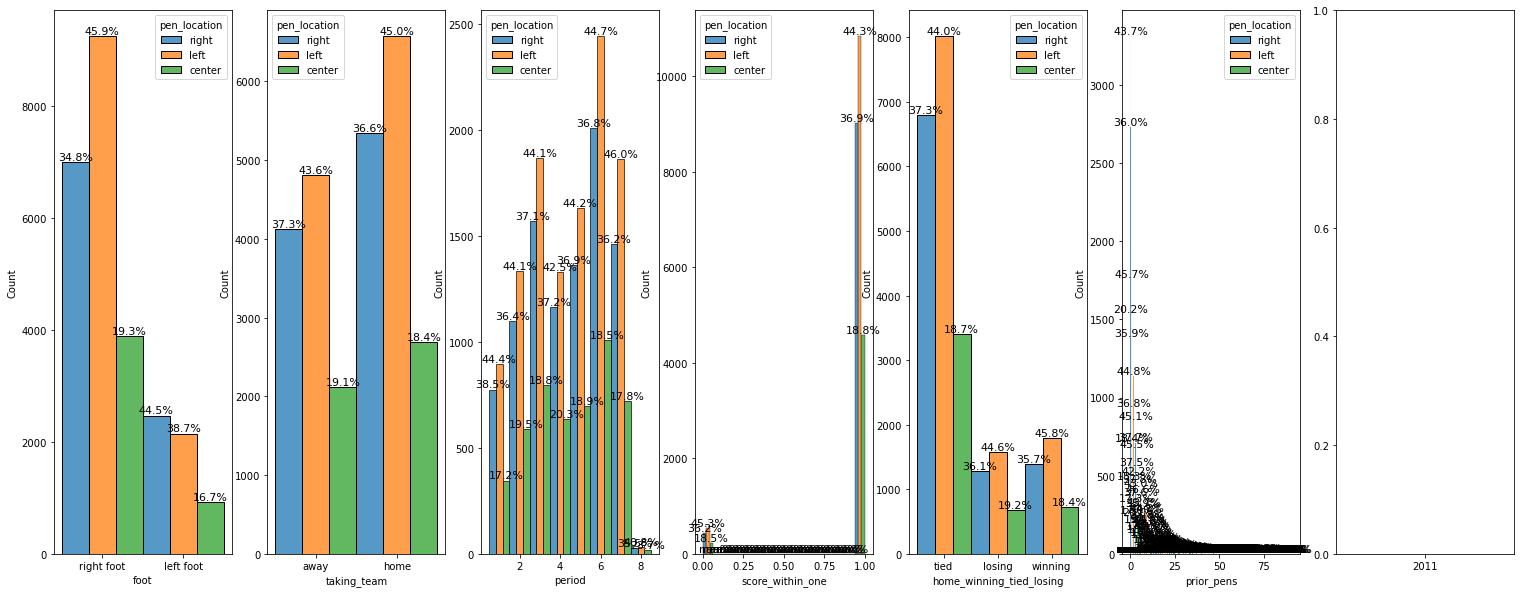

In [341]:
cols = df_prem[['foot','taking_team','period','score_within_one','home_winning_tied_losing','prior_pens','year']].columns
fig = plt.figure(figsize=(30,10))
for feature, i in zip(cols, range(1,len(cols)+1)):
    ax = fig.add_subplot(1,len(cols)+1,i)
    sns.histplot(data=df_prem, x=feature, hue='pen_location', multiple='dodge', ax=ax)

    percentage_above_bar_relative_to_xgroup(ax)

0.41 accuracy with a standard deviation of 0.01


Text(0.5, 15.0, 'Predicted')

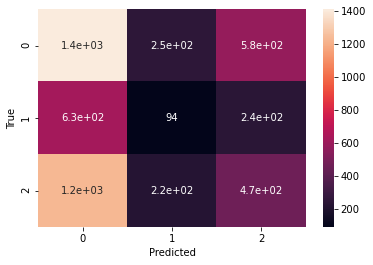

In [343]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import statsmodels.api as sm

df = df_prem.copy()
df['home_winning_tied_losing'] = np.where(df['home_winning_tied_losing']=='winning', 1, np.where(df['home_winning_tied_losing']=='tied',0,-1))
df['home_taking_pen'] = np.where(df['taking_team']=='home', 1, 0)
df['right_footed_taker'] = np.where(df['foot']=='right foot', 1, 0)
df['score_within_one'] = np.where(df['score_within_one'] == 'yes', 1, 0)
df['pen_location'] = np.where(df['pen_location'] == 'left', 0, np.where(df['pen_location'] == 'center', 1, 2))
#df = pd.concat([df, pd.get_dummies(df['Position'])], axis=1)
#
X = df[['right_footed_taker','time','taken_before']]
X = StandardScaler().fit_transform(X)
y = df['pen_location']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)

clf = KNeighborsClassifier()
#clf = make_pipeline(StandardScaler(), clf)
clf.fit(X_train, y_train)
#print(np.exp(clf.coef_))
scores = cross_val_score(clf, X, y, cv=5)
y_pred = clf.predict(X_test)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')



LR: 0.397821 (0.055125)
LDA: 0.397821 (0.055125)
KNN: 0.415769 (0.054949)
CART: 0.397821 (0.055125)
NB: 0.407821 (0.054611)
SVM: 0.397821 (0.055125)


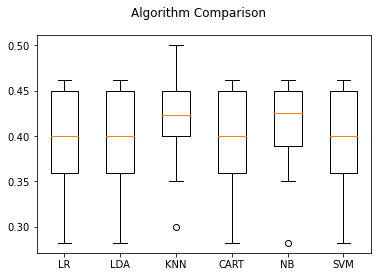

In [315]:
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection


X = StandardScaler().fit_transform(X)
y = df['pen_direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.4)

models = []
seed = 0
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()